# Exercise 2: Interactive Segmentation

**Deadline: 23 December 2022, 11:59 PM**            

**Covered Topics: Lecture 5**

Your tic-tac-toe championship was a major success and everyone is waiting for the next event from you. Meanwhile, some curious eyes have also noticed the impressive compression algorithm you developed. Among them is a group of budding entrepreneurs who are working on a noble mission: to empower everyone to make their own *Cat Memes*. Specifically, they are developing an app where you can take a photo of your cute cat, segment it out, and paste it on any  background to design your own meme. Crucially, the users only have to mark a bounding box around the cat, and the app will automatically segment it. Since performing accurate segmentation is very challenging, the app also uses a second auxiliary image obtained using other sensors in the camera as input. As none of the founders are Computer Vision engineers, they have approached you to develop the segmentation algorithm for the app. An overview of the desired pipeline is shown in Figure.


![](https://drive.google.com/uc?export=view&id=1C_UxSb8zKf5BU06TUg3YJx4uIdargySf "Title")

**Details about the setup** 
* For each test sample, the algorithm is provided a triplet consisting of the RGB image, the auxiliary image, and the bounding box for the cat. We denote this triplet as a *sample*. 
* The bounding box for the cat is provided as a grayscale image, where the regions inside the box are set to 255 (white), while the regions outside the box are set to 0 (black). It is guaranteed that the cat lies fully inside the bounding box.
* Both the RGB image and the Auxiliary images are discrete images containing 3 channels. Each pixel in these images is an integer which can take values between [0, 255]
* For each sample, the RGB image and the Auxiliary image, and the bounding box image all have the same height and width. However, note that two RGB images from two different samples may have different sizes.


Given an input sample, your algorithm should output a single channel segmentation mask, of the same height and width as the input images. The output mask should be a NumPy array of data type `uint8`, with values 255 for the foreground (cat) regions, and value 0 for the background regions. In order to design your segmentation algorithm, we provide a validation dataset containing 10 samples, along with the ground truth segmentation mask for each of these samples.

**Evaluation Criteria**

Your algorithm will be evaluated using the Intersection-over-Union (IoU) metric. Given the ground truth mask and the predicted mask for a sample, the metric computes the i) intersection of the two masks, i.e. number of pixels for which both the masks are set to foreground (value 255), and ii) the union of the two masks, i.e. number of pixels for which either one of the masks is set to foreground (value 255). The IoU metric is then obtained as the ratio 

$$
\text{IoU} = \frac{\text{Intersection of ground truth and predicted masks}}{\text{Union of ground truth and predicted masks}} 
$$

Please refer to the evaluation script included in this notebook (`evaluation.py`) for more details about IoU metric. The final EvaluationScore is obtained as the mean IoU over all test samples. Since the segmentation algorithm can be stochastic, i.e. output different masks at different times, we run the algorithm on the test dataset 5 times, and compute the mean EvaluationScore over these 5 runs. 


**Passing requirement**

Your algorithm will be evaluated using an online evaluation server on a hidden test set. In order to pass the exercise, you need to obtain an EvaluationScore of **greater than $0.630$** on the test set. Additionally, your segmentation algorithm should be reasonably fast, that is, segment each sample in less than 5 seconds. This is because the evaluation server will time out if your algorithm is too slow. The ranking on the leaderboard is obtained using only the EvaluationScore.

Follow the steps in the rest of the notebook to generate the submission. The evaluation server for the exercise is at https://codalab.lisn.upsaclay.fr/competitions/8068.

## Initialize the environment and load data
Import the necessary libraries. Note that you are **NOT** allowed to use any additional libraries

In [ ]:
# These two lines ensure that we always import the latest version of a package, in case it has been modified.
%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import os
import numpy as np
import random
import shutil

from google.colab import drive
drive.mount('/content/drive')

import sys

# Install and import PyMaxFlow. This library can be used to perform min-cut
!pip install PyMaxflow
import maxflow

**TODO:** Set the path in Google drive where you uploaded the handout, e.g. My Drive/iacv/ex2



In [ ]:
iacv_path = 'MyDrive/ETH Computer Vision/ex2' # TODO set this

env_path = f'/content/drive/{iacv_path}'
# Add the handout folder to python paths
if env_path not in sys.path:
    sys.path.append(env_path)

import evaluation

Helper functions to load and display images. You do not need to modify these functions.

In [ ]:
def load_image(im_path):
    im = cv2.imread(im_path)
    
    # OpenCV loads images in BGR format, that is first channel in the image is blue, second is green, and third is red.
    # matplotlib (which we will use to display images) on the image hand expects images in RGB format. Hence we perform a color conversion
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)   
    return im


def load_sample(sample_path):
    im_rgb = load_image(sample_path + '/im_rgb.jpg')
    im_aux = load_image(sample_path + '/im_aux.jpg')
    im_box = cv2.imread(sample_path + '/box.jpg', cv2.IMREAD_GRAYSCALE)

    mask = cv2.imread(sample_path + '/mask.jpg', cv2.IMREAD_GRAYSCALE)
       
    return im_rgb, im_aux, im_box, mask


def show_image(im, title=None):
    plt.imshow(im)
    plt.title(title)
    plt.show()


def show_sample(im_rgb, im_aux, im_box, pred_mask=None, gt_mask=None):
    num_images = 3 + (pred_mask is not None) + (gt_mask is not None)

    fig, ax = plt.subplots(1, num_images, figsize=(20, 20))

    ax[0].imshow(im_rgb)
    ax[0].set_title('RGB Image')

    ax[1].imshow(im_aux)
    ax[1].set_title('Aux Image')
    
    ax[2].imshow(im_box)
    ax[2].set_title('Box')

    idx = 3
    if gt_mask is not None:
        ax[idx].imshow(gt_mask)
        ax[idx].set_title('GT Mask')
        idx += 1 

    if pred_mask is not None:
        ax[idx].imshow(pred_mask)
        ax[idx].set_title('Pred Mask')
    plt.show()

Visualize a few validation samples, along with ground truth to get an idea of how the images look. You can run this cell multiple times to visualize different images.

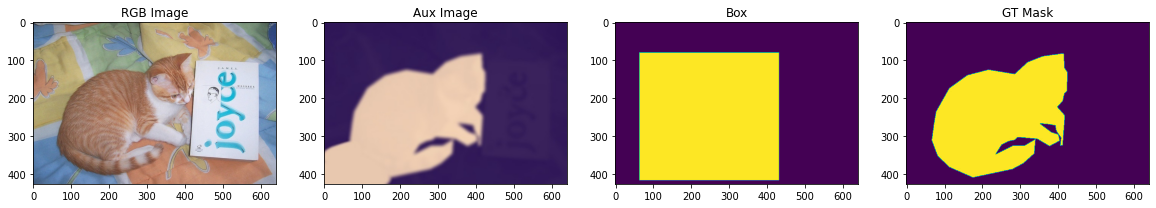

In [ ]:
sample_id = random.randint(0, 9)
im_rgb, im_aux, im_box, mask = load_sample(f'{env_path}/val/{sample_id:02d}')
show_sample(im_rgb, im_aux, im_box, gt_mask=mask)

## Implement your solution

**TODO:** You are provided with a simple implementation of the `ImageSegmenter` class (image_segmenter.py). The `ImageSegmenter` class is responsible to generate a segmentation mask, given the RGB image, Aux image, and the box containing the cat. Modify this class to include your algorithm. The `image_segmenter.py` file also provides a simple fuction to perform min cut using PyMaxFlow library (http://pmneila.github.io/PyMaxflow/), which you can **optionally** use. **Note:** You are not allowed to use any external packages except the ones already imported in `image_segmenter.py`. Otherwise your submission will crash on the Evaluation server.

**Important:** The next cells demonstrate how the `ImageSegmenter` class will be used. Have a look at them before implementing your approach.


## Test your solution on validation set

Test your algorithm on some validation samples and visualize the output. 

**Important:** Don't forget to import the `image_segmenter` every time you modify the `image_segmenter.py` file, otherwise your latest changes won't be loaded.

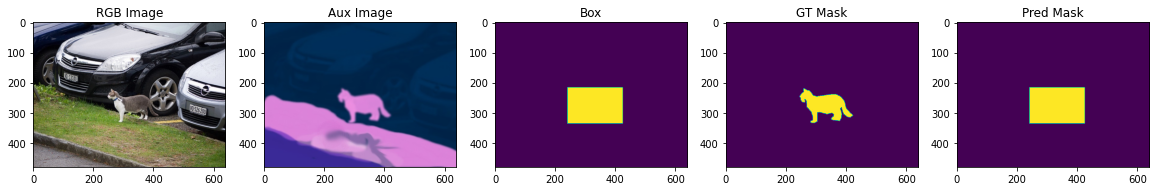

IoU score is: 0.379


In [ ]:
# Import the image_segmenter class everytime you modify image_segmenter.py file. 
# Otherwise your changes won't be loaded
import image_segmenter as image_segmenter

# Initialize the segmenter object
segmenter = image_segmenter.ImageSegmenter()

# Load validation sample
im_rgb, im_aux, im_box, gt_mask = load_sample(f'{env_path}/val/00')

# Run your segmentation algorithm
pred_mask = segmenter.segment_image(im_rgb, im_aux, im_box)

# Visualize your prediction
show_sample(im_rgb, im_aux, im_box, gt_mask=gt_mask, pred_mask=pred_mask)

iou_score = evaluation.calculate_iou(gt_mask, pred_mask)
print(f'IoU score is: {iou_score:0.3f}')

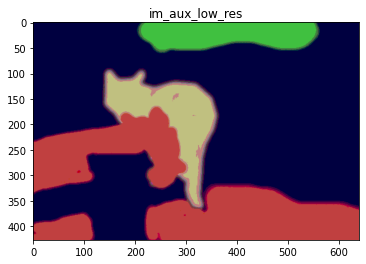

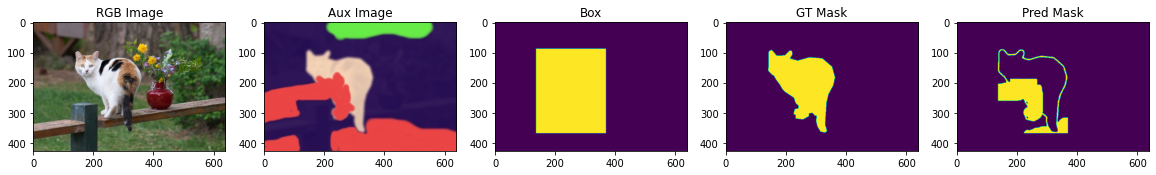

IoU score is: 0.205


In [ ]:
#from matplotlib.colors import makeMappingArray
import numpy as np
import random
import math

# Import maxflow (PyMaxflow library) which can be used to solve min-cut problem
import maxflow

# Set seeds for random generators to get reproducible results
random.seed(0)
np.random.seed(0)

def perform_min_cut(unary_potential_foreground, unary_potential_background, pairwise_potential):
    """
    We provide a simple fuction to perform min cut using PyMaxFlow library. You
    may use this function to implement your algorithm if you wish. Feel free to
    modify this function as desired, or implement your own function to perform
    min cut.  

    args:
        unary_potential_foreground - A single channel NumPy array specifying the
            source (foreground) unary potentials for each pixel in the image
        unary_potential_background - A single channel NumPy array specifying the
            sink (background) unary potentials for each pixel in the image
        pairwise_potential - A single channel NumPy array specifying the pairwise
            potentials. We assume a graph where each pixel in the image is 
            connected to its four neighbors (left, right, top, and bottom). 
            Furthermore, we assume that the pairwise potential for all these 4
            edges are same, and set to the value of pairwise_potential at that 
            pixel location
    """    
    
    # create graph
    maxflow_graph = maxflow.Graph[float]()
    
    # add a node for each pixel in the image
    nodeids = maxflow_graph.add_grid_nodes(unary_potential_foreground.shape[:2])

    # Add edges for pairwise potentials. We use 4 connectivety, i.e. each pixel 
    # is connected to its 4 neighbors (up, down, left, right). Also we assume
    # that pairwise potential for all these 4 edges are same
    # Feel free to change this if you wish
    maxflow_graph.add_grid_edges(nodeids, pairwise_potential)

    # Add unary potentials
    maxflow_graph.add_grid_tedges(nodeids, unary_potential_foreground, unary_potential_background)

    maxflow_graph.maxflow()
    
    # Get the segments of the nodes in the grid.
    mask_bg = maxflow_graph.get_grid_segments(nodeids)
    mask_fg = (1 - mask_bg.astype(np.uint8))* 255

    return mask_fg


class ImageSegmenter:
    def __init__(self):
        pass
    
    def segment_image(self, im_rgb, im_aux, im_box):
        # TODO: Modify this function to implement your algorithm

        """
        # Perform simple min cut
        box = im_box.astype(np.float32) / 255
        
        # creating a 3D mask
        box_mask = np.zeros(np.shape(im_rgb))

        box_mask[:,:,0] = box
        box_mask[:,:,1] = box
        box_mask[:,:,2] = box

        #test = np.multiply(im_rgb/ 255, box_mask) # np.ma.masked_array(im_rgb, mask=box_mask)
        #show_image(test, "box_mask")

        # trating array of pixel for the un-selected area
        im_selection_masked = np.ma.masked_array(im_aux, mask=box_mask)
        im_val_unselected = im_selection_masked.compressed()
        im_val_unselected = np.reshape(im_val_unselected, (-1, 3))


        # trating array of pixel for the selected area
        box_mask = np.ones(np.shape(box_mask)) - box_mask
        #test = np.multiply(im_rgb/ 255, box_mask) # np.ma.masked_array(im_rgb, mask=box_mask)
        #show_image(test, "box_mask")

        im_unselection_masked = np.ma.masked_array(im_aux, mask=box_mask)
        im_val_selected = im_unselection_masked.compressed()
        im_val_selected = np.reshape(im_val_selected, (-1, 3))




        
        # comptuting mean and variance of pixels in the two reigons) 
        selected_mean = np.mean(im_val_selected, axis=0)
        selected_cov = np.cov(im_val_selected.T)
        
        unselected_mean = np.mean(im_val_unselected, axis=0)
        unselected_cov = np.cov((im_val_unselected-unselected_mean).T)


        print("selected mean: " + str(selected_mean))
        print("selected cov: " + str(selected_cov))
        print("unselected mean: " + str(unselected_mean))
        print("unselected cov: " + str(unselected_cov))

        # calculate prob selected
        z = np.reshape(im_aux, (-1, 3))
        mean = selected_mean
        cov = selected_cov

        N = 3

        temp1 = np.linalg.det(cov) ** (-1/2)

        de_mean_z = z - mean
        inv_cov = np.linalg.inv(cov)


        temp2 = np.empty(np.shape(z)[0])
        for i in range(np.shape(temp2)[0]):

            temp2[i] = np.exp(-.5 * np.dot(np.dot((de_mean_z[i,:]), inv_cov) , (de_mean_z[i,:])))


        prob_selected = (2 * np.pi) ** (-N/2) * temp1 * temp2

        #test = np.reshape(prob_selected, np.shape(im_rgb)[:2])
        #show_image(test,"prob_selected")


        # calculate prob unselected
        z = np.reshape(im_aux, (-1, 3))
        mean = unselected_mean
        cov = unselected_cov

        N = 3

        temp1 = np.linalg.det(cov) ** (-1/2)

        de_mean_z = z - mean
        inv_cov = np.linalg.inv(cov)


        temp2 = np.empty(np.shape(z)[0])
        for i in range(np.shape(temp2)[0]):

            temp2[i] = np.exp(-.5 * np.dot(np.dot((de_mean_z[i,:]), inv_cov) , (de_mean_z[i,:])))


        prob_unselected = (2 * np.pi) ** (-N/2) * temp1 * temp2

        """

        # Perform simple min cut
        box = im_box.astype(np.float32) / 255

        # creating a 3D mask
        box_mask = np.zeros(np.shape(im_rgb))

        box_mask[:,:,0] = box
        box_mask[:,:,1] = box
        box_mask[:,:,2] = box

        #test = np.multiply(im_rgb/ 255, box_mask) # np.ma.masked_array(im_rgb, mask=box_mask)
        #show_image(test, "box_mask")

        im_aux_low_res = np.floor_divide(im_aux, 64) * 64
        show_image(im_aux_low_res, "im_aux_low_res")


        im_selection_masked = np.ma.masked_array(im_aux_low_res, mask=box_mask)
        im_val_unselected = im_selection_masked.compressed()
        #im_val_unselected = np.reshape(im_val_unselected, (-1, 3))


        # trating array of pixel for the selected area
        box_mask = np.ones(np.shape(box_mask)) - box_mask
        #test = np.multiply(im_rgb/ 255, box_mask) # np.ma.masked_array(im_rgb, mask=box_mask)
        #show_image(test, "box_mask")


        im_unselection_masked = np.ma.masked_array(im_aux_low_res, mask=box_mask)
        im_val_selected = im_unselection_masked.compressed()
        #im_val_selected = np.reshape(im_val_selected, (-1, 3))




        im_val_selected_vec = np.reshape(im_val_selected, (-1, 3))
        im_val_unselected_vec = np.reshape(im_val_unselected, (-1, 3))

        im_val_all = np.reshape(im_aux_low_res, (-1, 3))


        selected_uniq, selected_count = np.unique(im_val_selected_vec, axis=0, return_counts=True)
        unselected_uniq, unselected_count = np.unique(im_val_unselected_vec, axis=0, return_counts=True)

        all_uniq, all_count = np.unique(im_val_all, axis=0, return_counts=True)



        selected_prob = selected_count / np.sum(selected_count)
        unselected_prob = unselected_count / np.sum(unselected_count)

        unselected_prob_new = np.empty(np.shape(selected_prob))

        for i in range(np.shape(selected_prob)[0]):

            for j in range(np.shape(unselected_prob)[0]):

                if np.array_equal(selected_uniq[i, :], unselected_uniq[j, :]):

                    unselected_prob_new[i] = unselected_prob[j]

        unselected_prob = unselected_prob_new          


        im_prob_selected = np.ones(np.shape(im_aux_low_res)[:2]) * -math.log(1e-50)
        im_prob_unselected = np.ones(np.shape(im_aux_low_res)[:2]) * -math.log(1 - 1e-50)

        
        selected_prob = -np.log(selected_prob)
        unselected_prob = -np.log(unselected_prob)


        for i in range(np.shape(im_prob_selected)[0]):

            for j in range(np.shape(im_prob_selected)[1]):

                if box[i,j]:              

                    for k in range(np.shape(selected_uniq)[0]):

                        if np.array_equal(im_aux_low_res[i, j, :], selected_uniq[k, :]):

                            im_prob_selected[i, j] = selected_prob[k]

                    #for k in range(np.shape(unselected_uniq)[0]):

                        #if np.array_equal(im_aux_low_res[i, j, :], unselected_uniq[k, :]):

                            im_prob_unselected[i, j] = unselected_prob[k]


        #im_prob_selected_log = -np.log(im_prob_selected)
        #im_prob_unselected_log = -np.log(im_prob_unselected)


        """
        test = np.reshape(im_prob_selected_log, np.shape(im_rgb)[:2])
        show_image(test,"prob_selected")
        test = np.reshape(im_prob_unselected_log, np.shape(im_rgb)[:2])
        show_image(test,"prob_unselected")

        test = np.reshape(im_prob_unselected_log - im_prob_selected_log, np.shape(im_rgb)[:2])
        show_image(test,"prob_unselected - prob_selected")
        """

        # Foreground potential set to 1 inside box, 0 otherwise
        unary_potential_foreground = np.reshape(im_prob_unselected, np.shape(im_box))

        # Background potential set to 0 inside box, 1 everywhere else
        unary_potential_background = np.reshape(im_prob_selected, np.shape(im_box)) 

        # Pairwise potential set to 1 everywhere
        pairwise_potential = np.ones_like(unary_potential_foreground) * 1.2

        # Perfirm min cut to get segmentation mask
        im_mask = perform_min_cut(unary_potential_foreground, unary_potential_background, 
                                  pairwise_potential)
        
        return im_mask


segmenter = ImageSegmenter()

# Load validation sample
im_rgb, im_aux, im_box, gt_mask = load_sample(f'{env_path}/val/06')

# Run your segmentation algorithm
pred_mask = segmenter.segment_image(im_rgb, im_aux, im_box)

# Visualize your prediction
show_sample(im_rgb, im_aux, im_box, gt_mask=gt_mask, pred_mask=pred_mask)

iou_score = evaluation.calculate_iou(gt_mask, pred_mask)
print(f'IoU score is: {iou_score:0.3f}')

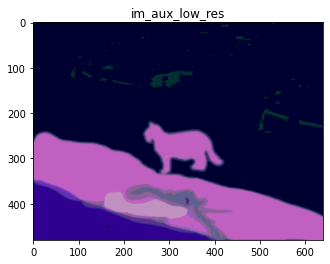

In [ ]:
# Perform simple min cut
box = im_box.astype(np.float32) / 255

# creating a 3D mask
box_mask = np.zeros(np.shape(im_rgb))

box_mask[:,:,0] = box
box_mask[:,:,1] = box
box_mask[:,:,2] = box

#test = np.multiply(im_rgb/ 255, box_mask) # np.ma.masked_array(im_rgb, mask=box_mask)
#show_image(test, "box_mask")

im_aux_low_res = np.floor_divide(im_aux, 48) * 48
show_image(im_aux_low_res, "im_aux_low_res")


im_selection_masked = np.ma.masked_array(im_aux_low_res, mask=box_mask)
im_val_unselected = im_selection_masked.compressed()
im_val_unselected = np.reshape(im_val_unselected, (-1, 3))


# trating array of pixel for the selected area
box_mask = np.ones(np.shape(box_mask)) - box_mask
#test = np.multiply(im_rgb/ 255, box_mask) # np.ma.masked_array(im_rgb, mask=box_mask)
#show_image(test, "box_mask")


im_unselection_masked = np.ma.masked_array(im_aux_low_res, mask=box_mask)
im_val_selected = im_unselection_masked.compressed()
im_val_selected = np.reshape(im_val_selected, (-1, 3))




im_val_selected_vec = np.reshape(im_val_selected, (-1, 3))
im_val_unselected_vec = np.reshape(im_val_unselected, (-1, 3))

im_val_all = np.reshape(im_aux_low_res, (-1, 3))


selected_uniq, selected_count = np.unique(im_val_selected_vec, axis=0, return_counts=True)
unselected_uniq, unselected_count = np.unique(im_val_unselected_vec, axis=0, return_counts=True)

all_uniq, all_count = np.unique(im_val_all, axis=0, return_counts=True)



selected_prob = selected_count / np.sum(selected_count)
unselected_prob = unselected_count / np.sum(unselected_count)

unselected_prob_new = np.empty(np.shape(selected_prob))

for i in range(np.shape(selected_prob)[0]):

    for j in range(np.shape(unselected_prob)[0]):

        if np.array_equal(selected_uniq[i, :], unselected_uniq[j, :]):

            unselected_prob_new[i] = unselected_prob[j]

unselected_prob = unselected_prob_new          


im_prob_selected = np.ones(np.shape(im_aux_low_res)[:2]) * 1e-50
im_prob_unselected = np.ones(np.shape(im_aux_low_res)[:2]) * (1 - 1e-50)


for i in range(np.shape(im_prob_selected)[0]):

    for j in range(np.shape(im_prob_selected)[1]):

        if box[i,j]:              

            for k in range(np.shape(selected_uniq)[0]):

                if np.array_equal(im_aux_low_res[i, j, :], selected_uniq[k, :]):

                    im_prob_selected[i, j] = selected_prob[k]

            #for k in range(np.shape(unselected_uniq)[0]):

                #if np.array_equal(im_aux_low_res[i, j, :], unselected_uniq[k, :]):

                    im_prob_unselected[i, j] = unselected_prob[k]

                    




In [ ]:
unselected_prob_new = np.empty(np.shape(selected_prob))

for i in range(np.shape(selected_prob)[0]):

    for j in range(np.shape(unselected_prob)[0]):

        if np.array_equal(selected_uniq[i, :], unselected_uniq[j, :]):

            unselected_prob_new[i] = unselected_prob[j]



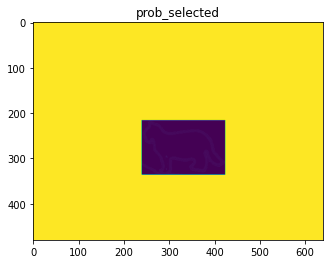

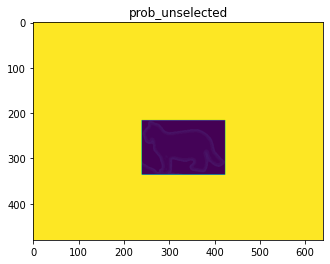

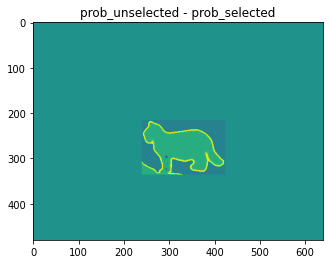

In [ ]:
im_prob_selected_log = -np.log(im_prob_selected)
im_prob_unselected_log = -np.log(im_prob_unselected)

test = np.reshape(im_prob_selected_log, np.shape(im_rgb)[:2])
show_image(test,"prob_selected")
test = np.reshape(im_prob_unselected_log, np.shape(im_rgb)[:2])
show_image(test,"prob_unselected")

test = np.reshape(im_prob_unselected_log - im_prob_selected_log, np.shape(im_rgb)[:2])
show_image(test,"prob_unselected - prob_selected")


In [ ]:
print(np.amin(im_prob_unselected_log - im_prob_selected_log))

-3.095174192393702


In [ ]:
a = np.reshape(range(1,13), (4,3))
b = np.reshape(range(1,13), (4,3))

result = a + b

b = b / result


In [ ]:
box = im_box.astype(np.float32) / 255

box_mask = np.zeros(np.shape(im_rgb))

box_mask[:,:,0] = box
box_mask[:,:,1] = box
box_mask[:,:,2] = box
        
test = np.zeros(np.shape(im_rgb))
test[:,:,0] = np.ones(np.shape(im_rgb)[:2])
test[:,:,1] = np.ones(np.shape(im_rgb)[:2])* 0.7
test[:,:,2] = np.ones(np.shape(im_rgb)[:2])* 0.3


test_masked = np.ma.masked_array(test, mask=box_mask)

test_compressed = test_masked.compressed()

test_compressed = np.reshape(test_compressed, (-1, 3))

Once your are happy with your implementation, you can test on the full validation set to obtain the evaluation score. **Important:** Ensure that you can execute the next cell without any errors to compute the evaluation score. 

Set `display_results` variable to `True` if you want to visualize your predictions.

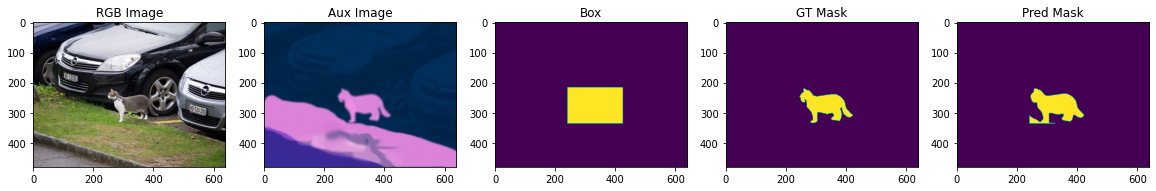

IoU score is: 0.722


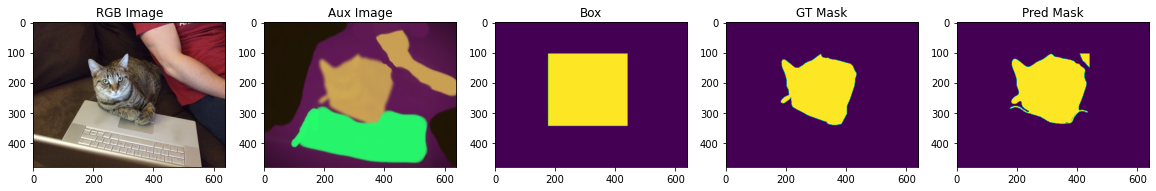

IoU score is: 0.872


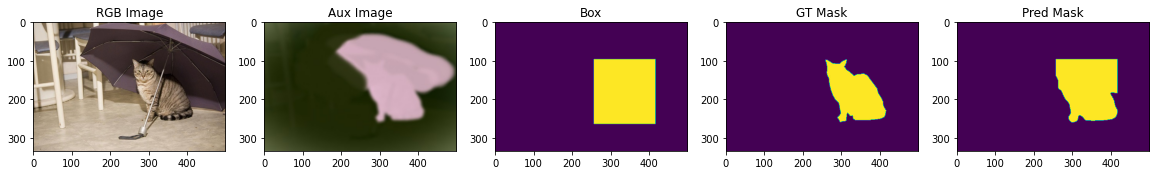

IoU score is: 0.628


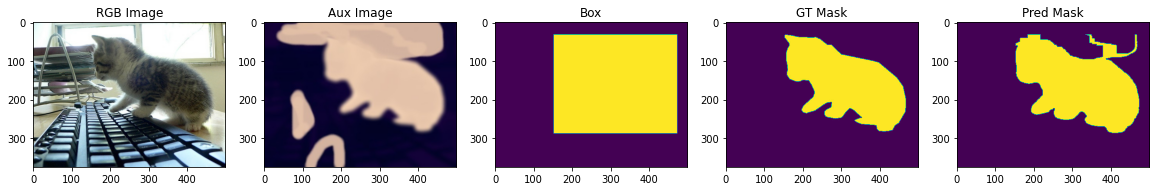

IoU score is: 0.815


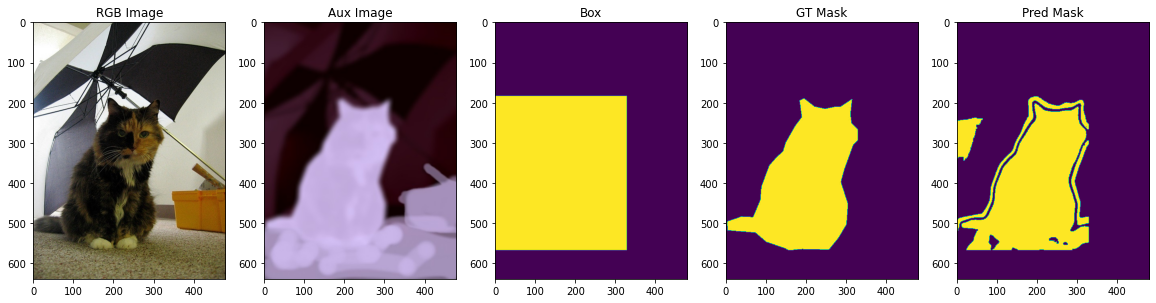

IoU score is: 0.751


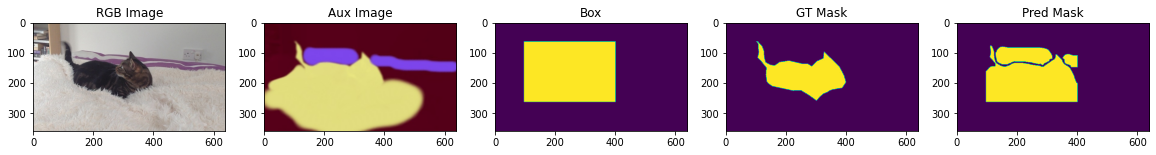

IoU score is: 0.454


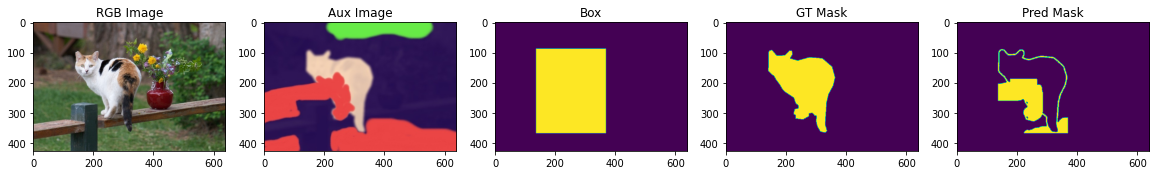

IoU score is: 0.205


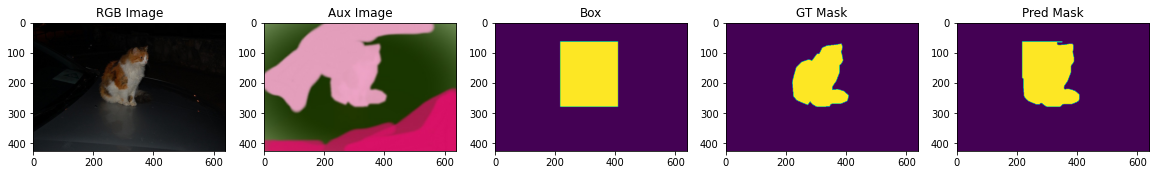

IoU score is: 0.728


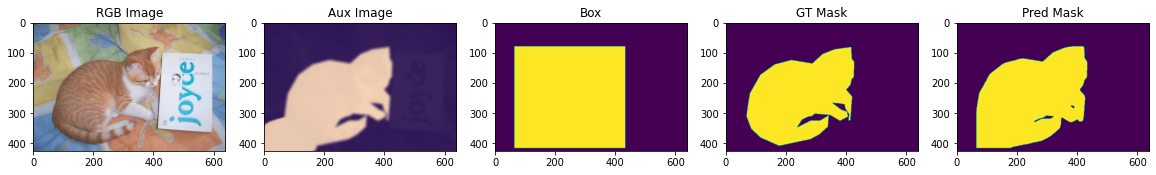

IoU score is: 0.827


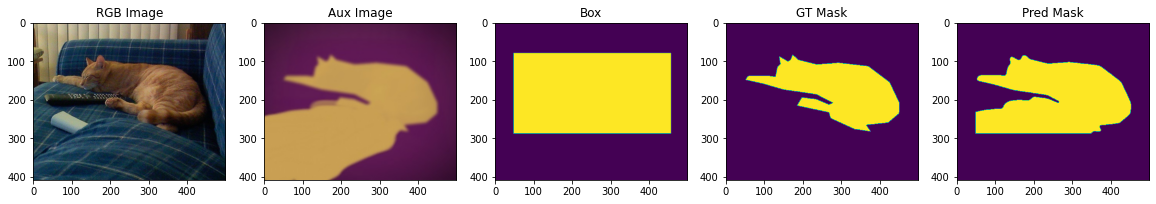

IoU score is: 0.628
Mean IoU score is: 0.663
Mean segmentation time per image is: 4.085 seconds


In [ ]:
import image_segmenter as image_segmenter
import time

display_results = True

# Initialize the segmenter object
segmenter = image_segmenter.ImageSegmenter()

iou_score_all = []
time_all = []
for idx in range(10):
    # Load validation sample
    im_rgb, im_aux, im_box, gt_mask = load_sample(f'{env_path}/val/{idx:02d}')

    # Run your segmentation algorithm
    t1 = time.time()
    pred_mask = segmenter.segment_image(im_rgb, im_aux, im_box)
    t2 = time.time()
    
    iou_score = evaluation.calculate_iou(gt_mask, pred_mask)
    iou_score_all.append(iou_score)
    time_all.append(t2 - t1)
    if display_results:
        # Visualize your prediction
        show_sample(im_rgb, im_aux, im_box, gt_mask=gt_mask, pred_mask=pred_mask)
        print(f'IoU score is: {iou_score:0.3f}')
    

mean_iou = sum(iou_score_all) / len(iou_score_all)
print(f'Mean IoU score is: {mean_iou:0.3f}')

mean_time = sum(time_all) / len(time_all)
print(f'Mean segmentation time per image is: {mean_time:0.3f} seconds')

## Generate the final submission on the test set

After finishing your implementation, you can run the next cell to generate the results, which will be stored in the submission directory on your Google Drive. This cell saves your implementation of the `image_segmenter.py` to the submission directory. Download the submission folder (**without renaming**) as a zip, and upload it to the evaluation server at https://codalab.lisn.upsaclay.fr/competitions/8068 to obtain the scores on the test set. 


In [ ]:
out_dir = f'{env_path}/submission'
os.makedirs(out_dir, exist_ok=True)
shutil.copyfile(f'{env_path}/image_segmenter.py', f'{out_dir}/image_segmenter.py')

'/content/drive/MyDrive/ETH Computer Vision/ex2/submission/image_segmenter.py'